Loading Data...
Running Backtest (Unhedged Futures)...

--- PERFORMANCE SUMMARY (UNHEDGED) ---
                  Benchmark (EqW)  Fund L/S (Unhedged)
Ann. Return (XS)         0.035121             0.005834
Ann. Volatility          0.146897             0.071496
Sharpe Ratio             0.239086             0.081598
Beta                     1.000000             0.000939
Ann. Alpha               0.000000             0.005801
Correlation              1.000000             0.001930

--- DETAILED MONTHLY RETURNS & WEIGHTS ---
             ret_net  ret_gross    ret_rf    ret_bm      w_AU      w_CH      w_EM      w_EU      w_GB      w_JP      w_US
Date                                                                                                                     
1999-10-31 -0.007846  -0.007702  0.004267  0.033455  0.000000  0.000000  0.000000  0.000000  0.500000 -0.218407 -0.281593
1999-11-30 -0.003197  -0.003046  0.004417  0.022158  0.000000  0.000000  0.000000  0.000000  0.500000 -0.19056

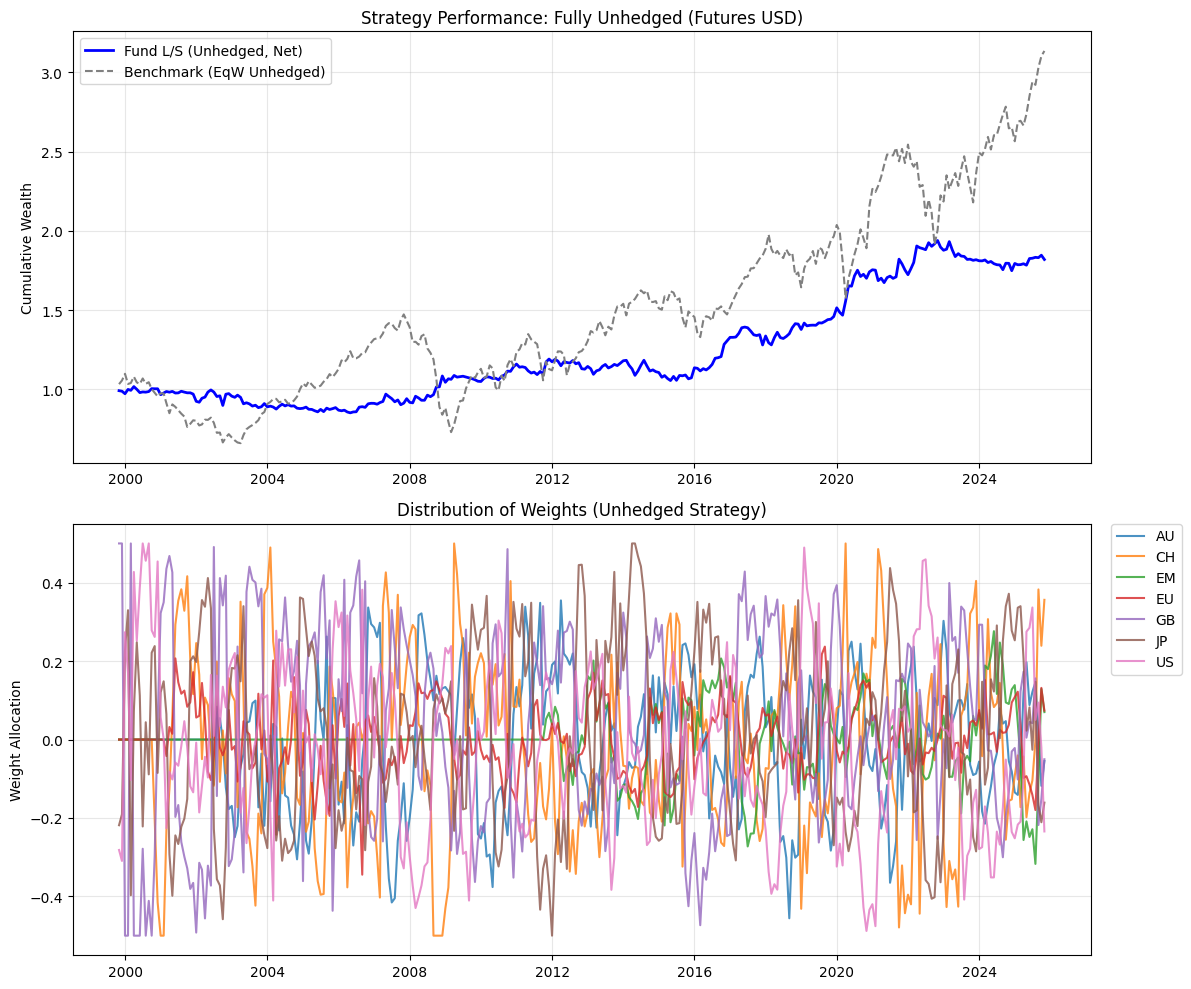

In [7]:
## FUNDAMENTAL STRATEGY 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path
from pandas.tseries.offsets import MonthEnd

# -------------------------------------------------------------------
# 0. CONFIGURATION
# -------------------------------------------------------------------
DATA_DIR = Path(r"C:/Users/Sedláček/Documents/UZH/PMP/Macro_momentum/PMP_December_8/Data")

FUND_FILE  = DATA_DIR / "Fundamental_Indicators.xlsx"
FX_FILE    = DATA_DIR / "FX.xlsx"
RF_FILE    = DATA_DIR / "Market_Yield_U.S._T-bill_3-Month_Constant_Maturity.xlsx"
PRICE_FILE = DATA_DIR / "Futures.xlsx"  # UPDATED to Futures

TARGET_VOL_ANN = 0.10
TCOST_PER_UNIT = 0.0005

SIGNAL_CONFIG = [
    {"ind": "TOT_DEBT_TO_TOT_EQY", "lag": 6, "sign": 1},
    {"ind": "ADJ_PE",              "lag": 6, "sign": -1},
    {"ind": "PX_TO_BOOK_RATIO",    "lag": 6, "sign": -1},
    {"ind": "IS_EPS",              "lag": 6, "sign": 1},
    {"ind": "PX_TO_SALES_RATIO",   "lag": 6, "sign": -1},
    {"ind": "RETURN_ON_ASSET",     "lag": 6, "sign": 1},
]

# =============================================================================
# 1. DATA LOADING FUNCTIONS
# =============================================================================
def load_fundamentals_dict(path: Path) -> dict:
    """Loads fundamentals and returns a Dictionary of DataFrames {Indicator: Panel}"""
    df = pd.read_excel(path)
    df["Date"] = pd.to_datetime(df["Date"]) + MonthEnd(0)
    
    # Clean and Format
    long = df.melt(id_vars="Date", var_name="raw_col", value_name="value").dropna(subset=["value"])
    long[["Region", "Indicator"]] = long["raw_col"].str.split("_", n=1, expand=True)
    
    # Pivot all at once
    full_panel = long.pivot_table(index="Date", columns=["Indicator", "Region"], values="value", aggfunc="mean")
    
    fund_dict = {}
    unique_inds = full_panel.columns.get_level_values(0).unique()
    for ind in unique_inds:
        fund_dict[ind] = full_panel[ind].sort_index()
        
    return fund_dict

def load_prices_futures_usd(path: Path) -> pd.DataFrame:
    """
    Loads Futures Prices (already in USD) and calculates Returns.
    Input Columns: Date, US, AU, CH, JP, UK, EM, EU
    """
    df = pd.read_excel(path)
    df["Date"] = pd.to_datetime(df["Date"])
    
    # 1. Rename UK -> GB to match Fundamentals consistency
    if "UK" in df.columns:
        df = df.rename(columns={"UK": "GB"})

    # 2. Set Index
    df = df.set_index("Date").sort_index()
    
    # 3. Calculate Returns (These are already USD Returns)
    ret_panel = df.pct_change()
    
    # 4. Align to Month End
    ret_panel.index = ret_panel.index + MonthEnd(0)
    
    # 5. Handle potential duplicate dates by taking the last value
    ret_panel = ret_panel.groupby(level=0).last()
    
    return ret_panel

def load_rf(path: Path) -> pd.Series:
    """Loads Risk Free Rate"""
    df = pd.read_excel(path, sheet_name="Monthly")
    df["Date"] = pd.to_datetime(df["observation_date"]) + MonthEnd(0)
    df = df.set_index("Date").sort_index()
    return df["Return"]

# =============================================================================
# 2. CALCULATION LOGIC
# =============================================================================
def compute_signals(fund_dict, returns_df, config):
    # Volatility (for scaling)
    rolling_std = returns_df.rolling(window=36, min_periods=24).std().replace(0, np.nan)
    
    # Signal Construction
    master_z = pd.DataFrame(0.0, index=returns_df.index, columns=returns_df.columns)
    valid_count = 0
    
    for cfg in config:
        ind, lag, sign = cfg["ind"], cfg["lag"], cfg["sign"]
        if ind in fund_dict:
            mom = fund_dict[ind].diff(lag) * sign
            mu = mom.mean(axis=1)
            sigma = mom.std(axis=1)
            z = mom.sub(mu, axis=0).div(sigma, axis=0).fillna(0)
            master_z = master_z.add(z)
            valid_count += 1
            
    final_signal = master_z / valid_count if valid_count > 0 else master_z
    return rolling_std, final_signal

# =============================================================================
# 3. ZIEGLER BACKTEST ENGINE & SUMMARY FUNCTIONS
# =============================================================================
def run_cc_strategy(weights, returns, rf, frequency=1, t_cost=0.0,
                    benchmark="equal", long_short=False, beta_neutral=False):
    
    # Align inputs
    weights = weights.copy().fillna(0)
    returns = returns.reindex(weights.index).copy()
    returns = returns[weights.columns]
    rf = rf.reindex(weights.index).fillna(0)
    
    dates = list(weights.index)
    regions = list(weights.columns)
    
    # Rebalance Schedule
    rebalance = pd.Series(0, index=dates, dtype=int)
    rebalance.iloc[::frequency] = 1
    rebalance.iloc[0] = 1

    # Benchmark Setup
    if benchmark == "equal":
        benchmark_w = pd.DataFrame(1.0/len(regions), index=weights.index, columns=regions)
        bm_returns = (benchmark_w * returns).sum(axis=1)
    else:
        bm_returns = pd.Series(0, index=weights.index)

    current_weight = weights.iloc[0].copy()
    results = []

    for i in range(len(dates) - 1):
        date = dates[i]
        next_date = dates[i + 1]

        # 1. Rebalance
        if rebalance.loc[date] == 1:
            target_weight = weights.loc[date].fillna(0)
            turnover = 0.5 * (target_weight - current_weight).abs().sum()
            current_weight = target_weight.copy()
        else:
            turnover = 0.0

        # 2. Returns
        r_vec = returns.loc[next_date].fillna(0.0)
        gross_ret = (current_weight * r_vec).sum()
        tcost_val = turnover * t_cost
        net_ret = gross_ret - tcost_val
        bm_ret = bm_returns.loc[next_date]

        # 3. Drift
        new_weight = current_weight * (1 + r_vec)
        
        # Long/Short Normalization
        if long_short:
            active = current_weight[current_weight != 0].index
            if len(active) > 0:
                new_active = current_weight[active] * (1 + r_vec[active])
                centered = new_active - new_active.mean()
                denom = centered.abs().sum()
                if denom > 0:
                    centered = centered / denom
                current_weight = pd.Series(0.0, index=current_weight.index)
                current_weight[active] = centered
            else:
                 current_weight = new_weight.copy()

        # 4. Store
        row = {
            "Date": next_date,
            "ret_net": net_ret,
            "ret_gross": gross_ret,
            "ret_bm": bm_ret,
            "turnover": turnover,
            "tcost": tcost_val,
            "ret_rf": rf.loc[next_date] if next_date in rf.index else 0.0
        }
        for reg in regions:
            row[f"w_{reg}"] = current_weight.get(reg, 0.0)
            
        results.append(row)

    return pd.DataFrame(results).set_index("Date")


def summarizePerformance(xsReturns, Rf, factorXsReturns, annualizationFactor=12, strategyNames=None):
    """
    Helper function to calculate performance metrics (Beta, Alpha, Sharpe, etc.)
    """
    # Ensure inputs are numpy arrays
    xsReturns = np.array(xsReturns)
    factorXsReturns = np.array(factorXsReturns).flatten()
    
    metrics = []
    
    for i in range(xsReturns.shape[1]):
        r_xs = xsReturns[:, i]
        
        # Basic Stats
        mu = np.mean(r_xs) * annualizationFactor
        sig = np.std(r_xs, ddof=1) * np.sqrt(annualizationFactor)
        sharpe = mu / sig if sig > 0 else 0
        
        # Regression stats vs Benchmark
        if np.std(factorXsReturns) == 0 or np.std(r_xs) == 0:
            beta, alpha, corr = 0.0, 0.0, 0.0
        else:
            slope, intercept, r_value, _, _ = stats.linregress(factorXsReturns, r_xs)
            beta = slope
            alpha = intercept * annualizationFactor # Annualize alpha
            corr = r_value
            
        metrics.append({
            "Ann. Return (XS)": mu,
            "Ann. Volatility": sig,
            "Sharpe Ratio": sharpe,
            "Beta": beta,
            "Ann. Alpha": alpha,
            "Correlation": corr
        })
        
    df = pd.DataFrame(metrics, index=strategyNames if strategyNames else [f"Strat {i}" for i in range(len(metrics))])
    return df.T


def run_perf_summary_benchmark_vs_strategy(
    results,
    alreadyXs=False,
    annualizationFactor=12,
    strategyNames=["Benchmark", "Strategy"]
):
    """
    Builds benchmark & strategy XS returns and runs summarizePerformance().
    """
    # 1) Benchmark excess return
    xs_bm = results["ret_bm"] - results["ret_rf"]

    # 2) Strategy excess return
    if alreadyXs:
        xs_str = results["ret_net"]
    else:
        xs_str = results["ret_net"] - results["ret_rf"]

    # 3) Combine into 2D matrix (benchmark, strategy)
    xsReturns = np.column_stack([xs_bm, xs_str])

    # 4) Risk-free (needs 2D: T x 1)
    Rf = results["ret_rf"].to_numpy().reshape(-1, 1)

    # 5) Factor XS returns = Benchmark XS return (2D!)
    factorXsReturns = (results["ret_bm"].to_numpy() - 
                       results["ret_rf"].to_numpy()).reshape(-1, 1)

    # 6) Performance summary
    return summarizePerformance(
        xsReturns=xsReturns,
        Rf=Rf,
        factorXsReturns=factorXsReturns,
        annualizationFactor=annualizationFactor,
        strategyNames=strategyNames
    )

# =============================================================================
# 4. MAIN EXECUTION (FULLY UNHEDGED - FUTURES)
# =============================================================================

# A. Load Data
print("Loading Data...")
fund_dict = load_fundamentals_dict(FUND_FILE)
rf_series = load_rf(RF_FILE)

# LOAD FUTURES PRICES (Already in USD)
# This replaces the old local prices + FX combination
ret_unhedged_usd = load_prices_futures_usd(PRICE_FILE)

# B. Calculate Signals
#    We compute signals based on the Fundamental indicators.
#    We use the USD Returns (from Futures) to calculate Volatility for position sizing.
#    Since prices are already USD, we pass `ret_unhedged_usd` directly.
vol_usd, signal = compute_signals(fund_dict, ret_unhedged_usd, SIGNAL_CONFIG)

# C. Calculate Weights
#    Scale by USD Volatility (Correct for US investor)
vol_target_monthly = TARGET_VOL_ANN / np.sqrt(12)
risk_scaler = vol_target_monthly / vol_usd
raw_weights = signal * risk_scaler

# D. Prepare Data for Backtest Engine
#    Pass Total USD Returns. The engine will subtract RF for Excess Return calculations internally if needed,
#    or we can calculate Excess here.
#    Usually, we pass Total Returns to the engine if we want the output `ret_net` to be Total Return.
final_weights = raw_weights.reindex(ret_unhedged_usd.index).fillna(0)

print("Running Backtest (Unhedged Futures)...")
perf_df = run_cc_strategy(
    weights      = final_weights,
    returns      = ret_unhedged_usd.dropna(how='all'), # Total USD Returns
    rf           = rf_series,
    t_cost       = TCOST_PER_UNIT,
    benchmark    = "equal",
    long_short   = True,
    beta_neutral = False
)

# E. Plotting & Summary
perf_df = perf_df[perf_df["turnover"].cumsum() > 0]
cum_strat = (1 + perf_df["ret_net"]).cumprod()
cum_bench = (1 + perf_df["ret_bm"]).cumprod()

print("\n--- PERFORMANCE SUMMARY (UNHEDGED) ---")
summary_table = run_perf_summary_benchmark_vs_strategy(
    results=perf_df,
    alreadyXs=False, # ret_net is Total Return, so function subtracts RF
    annualizationFactor=12,
    strategyNames=["Benchmark (EqW)", "Fund L/S (Unhedged)"]
)
print(summary_table)

# --- DETAILED MONTHLY RETURNS & WEIGHTS ---
print("\n--- DETAILED MONTHLY RETURNS & WEIGHTS ---")
cols_to_show = ["ret_net", "ret_gross", "ret_rf", "ret_bm"] + [c for c in perf_df.columns if c.startswith("w_")]

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print(perf_df[cols_to_show])
# --------------------------------------------------

plt.figure(figsize=(12, 10))

# Plot 1: Wealth
plt.subplot(2, 1, 1)
plt.plot(cum_strat.index, cum_strat, label="Fund L/S (Unhedged, Net)", color='blue', linewidth=2)
plt.plot(cum_bench.index, cum_bench, label="Benchmark (EqW Unhedged)", color='gray', linestyle="--")
plt.title("Strategy Performance: Fully Unhedged (Futures USD)")
plt.ylabel("Cumulative Wealth")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Weights
plt.subplot(2, 1, 2)
w_cols = [c for c in perf_df.columns if c.startswith("w_")]
weights_plot = perf_df[w_cols]
weights_plot.columns = [c.replace("w_", "") for c in weights_plot.columns]

for col in weights_plot.columns:
    plt.plot(weights_plot.index, weights_plot[col], label=col, linewidth=1.5, alpha=0.8)

plt.title("Distribution of Weights (Unhedged Strategy)")
plt.ylabel("Weight Allocation")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()